In [1]:
# Import required libraries
# Data reading and manipulation
import pandas as pd
import numpy as np

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Modules required for statistical tests
from scipy.stats import norm
from scipy.stats import t as t_dist
from scipy.stats import chi2_contingency

# Data modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Metrics
from numpy import mean
from numpy import std
from sklearn.metrics import roc_curve,f1_score,brier_score_loss
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,auc,roc_auc_score,precision_score,recall_score

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv data files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combined = pd.concat([train,test])

In [3]:
#Checking the variables
combined.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
#defining categorical and continous variables
cat_var = (['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type','smoking_status', 'stroke'])
cont_var = (['age', 'avg_glucose_level', 'bmi'])

## Exploratory Data Analysis
### Univariate Analysis

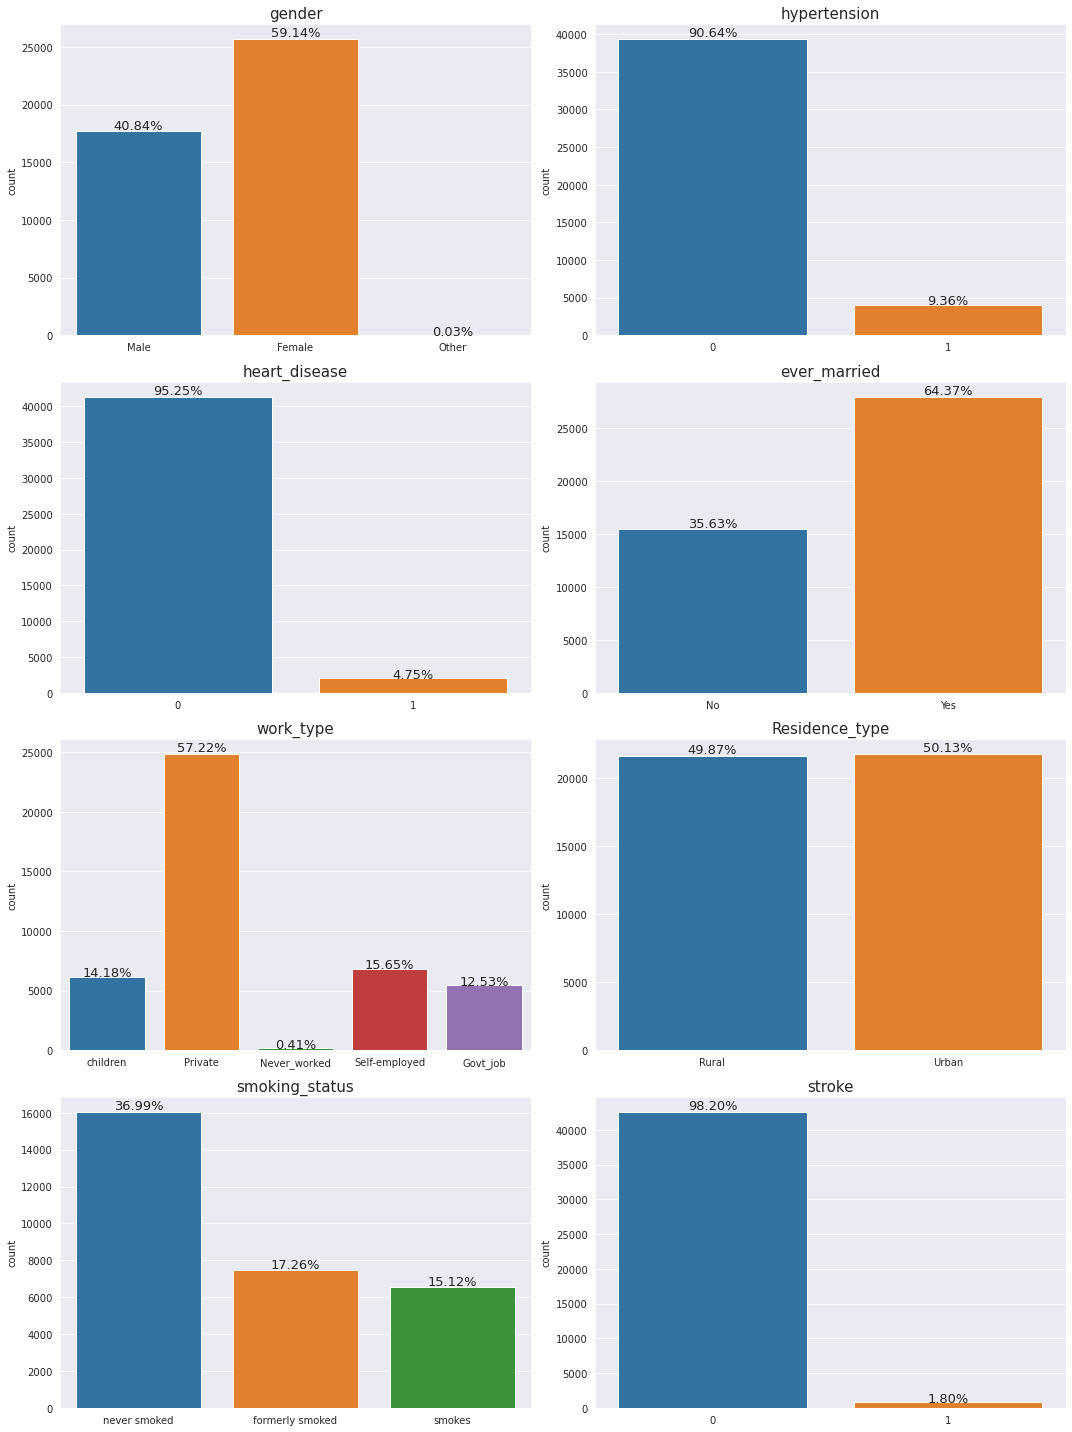

In [5]:
# Categorical variables
sns.set_style("darkgrid")
fig, ax=plt.subplots(4,2,figsize=(15,20))
ax1 = ax.flatten()
for i,j in enumerate(cat_var):
    ax = sns.countplot(train[j],ax=ax1[i])
    ax.set_title(j,fontsize=15)
    ax.set_xlabel("")
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        total=len(train[j])
        ax.annotate(f'{(height/total):.02%}', (x + width/2, y + height*1.01), ha='center',fontsize=13)
plt.tight_layout()

1.In the given training set we see that there are only 1.8% cases of stroke. This is a highly imbalanced Dataset and need to dealt by optimizing parameters 

2.The female population in dataset(59.14%) is higher than the male population (40.84%) and there is another Category ‘other’ whose population is very low 

3.Population with hypertension are 9.36 % of the given dataset. As per our hypothesis and reference, people with hypertension have more chance of stroke and we will check this during bivariable EDA

4.Population with heart disease are 4.75 % of the given dataset. As per our hypothesis and reference, people with heart disease have more chance of stroke and we will check this during bivariable EDA

5.64.37 % of given population are married. Marriage is related to age and elder people are more likely to be married.

6.Here we have 5 types of work categories and among them private sector is most and never worked is least and we see how this effects the chance of stroke occurrence during bivariate EDA

7.The given population are evenly distributed among the Rural and Urban type and this not affect our final prediction.

8.We have three categories regarding smoking and people who have never smoked are more in our dataset and as per our hypothesis smoking increases the chance of having a stroke


In [6]:
#continous variables
def cont_EDA(cont_var):
    fig, ax=plt.subplots(1,2,figsize=(15,5))
    ax1 = sns.distplot(train[cont_var],bins=100,ax=ax[0])
    ax2 = sns.boxplot(train[cont_var],ax=ax[1])
    plt.tight_layout()

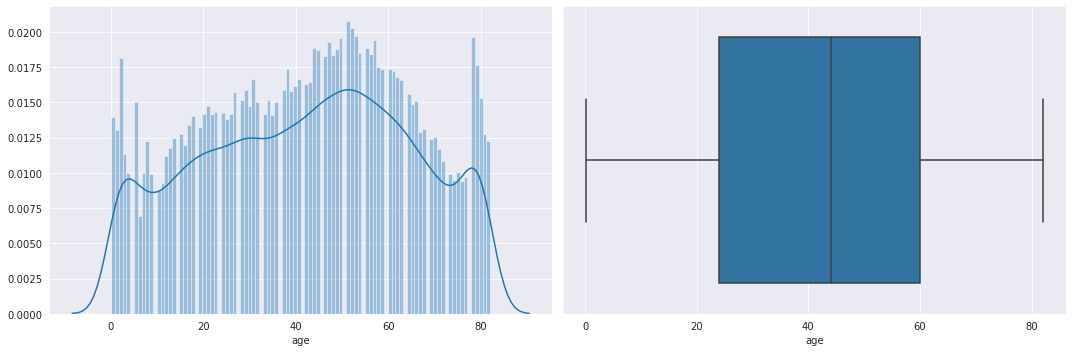

In [7]:
#Age
cont_EDA('age')

The age of the given population is evenly distributed in the age group of 0 to 80. We find there are many people under the age of 1 in the given dataset. They are newborn children and they don’t get a stroke . So, we will only consider the people above the age of 1 for our evaluation

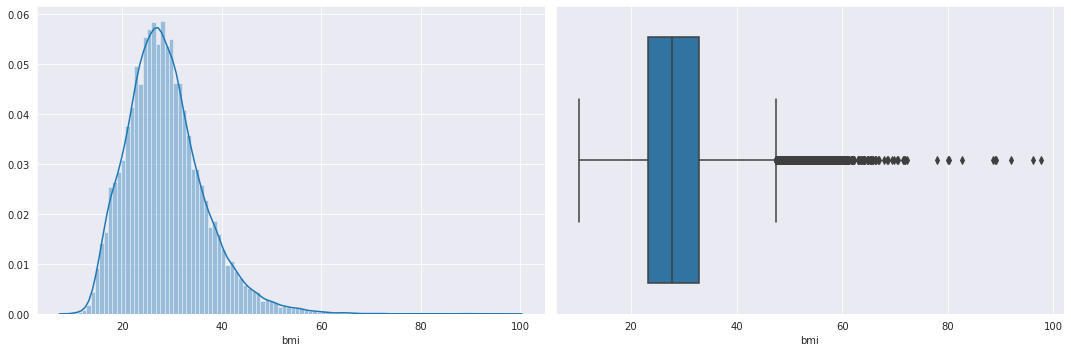

In [8]:
#BMI
cont_EDA('bmi')

Here there are many outliers and they need to be treated. BMI values above 60 are extremely rare and they can be removed from our dataset. This won't affect our prediction as our assumption is realistic
The number of values greater than 60 are 89 or (89/43311 = 0.002%) which is very small so they can be removed

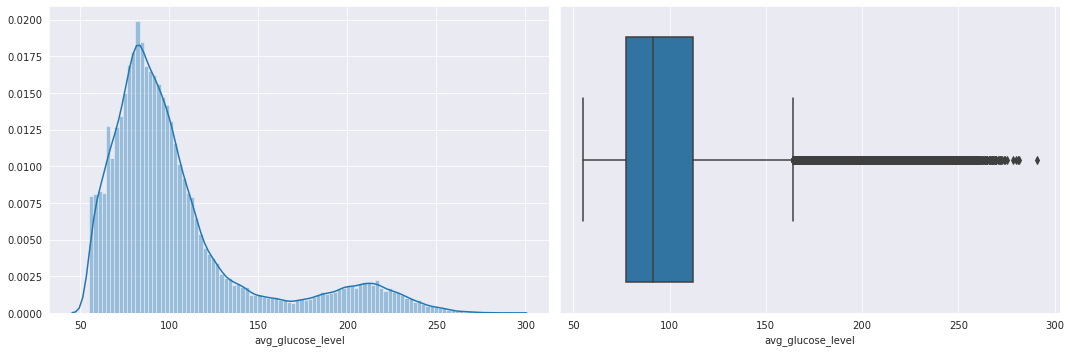

In [9]:
cont_EDA('avg_glucose_level')

Here we observe a bimodal distribution and also average glucose levels above 200 are extremely rare so we will only consider the value below 200 for our model building

### Bivariate Analysis

In [10]:
#defining a function for categorical vs target variable analysis
def cat_vs_stroke(cat_var):
    fig, ax=plt.subplots(1,2,figsize=(15,5))
    ax1 = sns.countplot(train[cat_var],hue=train['stroke'],ax=ax[0])
    table = pd.crosstab(train['stroke'],train[cat_var],)
    f_obs = np.array([table.iloc[0][:].values,table.iloc[1][:].values])
    chi, p, dof, expected = chi2_contingency(f_obs)
    ax1.set_title("p-value = {}".format(round(p,8)))
    
    ax2 = train.groupby(cat_var)['stroke'].value_counts(normalize=True).unstack()
    ax2.plot(kind='bar', stacked='True',title=str(ax2),ax=ax[1])
    int_level = train[cat_var].value_counts()

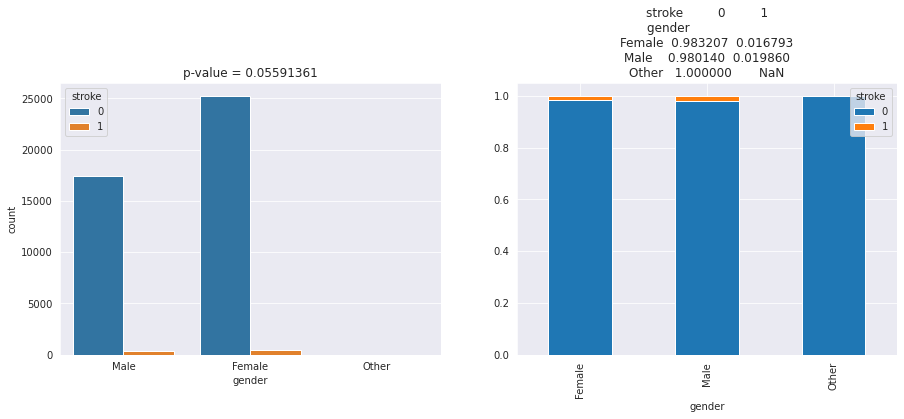

In [11]:
cat_vs_stroke('gender')

It appears males have a greater chance of getting a stroke than females but the difference is insignificant (1.9% male vs 1.6% female). Also the p-value is greater than our alpha indicating not a significant variable for prediction , so we will drop it. 

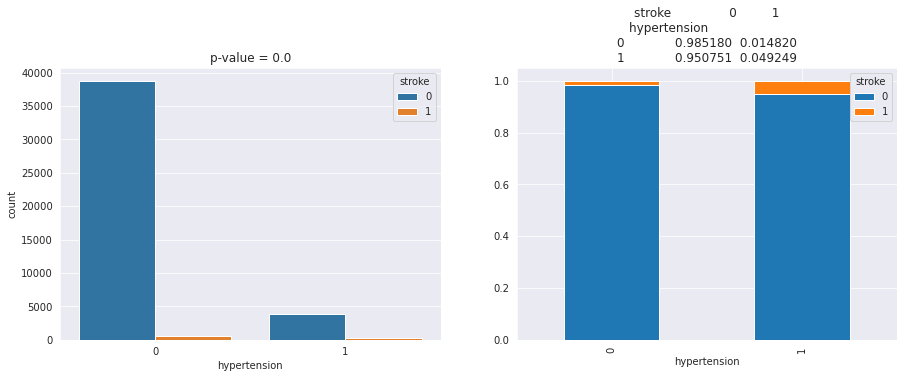

In [12]:
cat_vs_stroke('hypertension')

People with hypertension have more chance of getting a stroke and it is evident from the stacked plot where 4.9% of people with hypertension got a stroke and only 1.4% of people without hypertension have a stroke. 
Also p- value is less than 0.05 which implies this is a significant variable for prediction

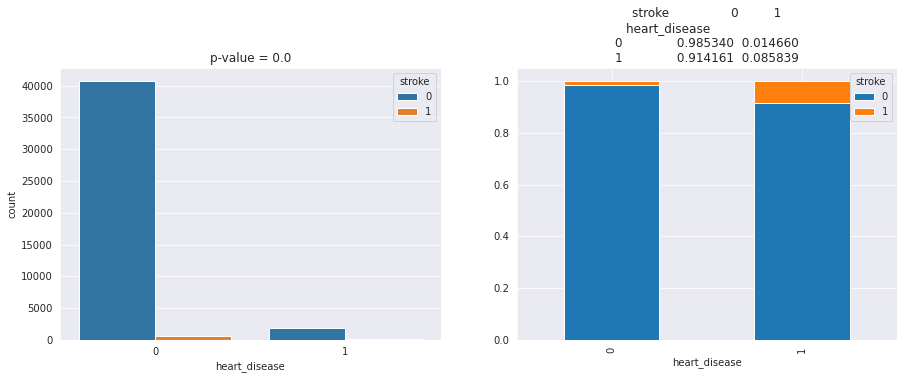

In [13]:
cat_vs_stroke('heart_disease')

Here the plots clearly indicate that people with heart disease have more chance of getting a stroke shown by 8.5% with heart disease got a stroke but only 1.4% without heart disease got a stroke
This fact is also evident from p-value which is below 0.05

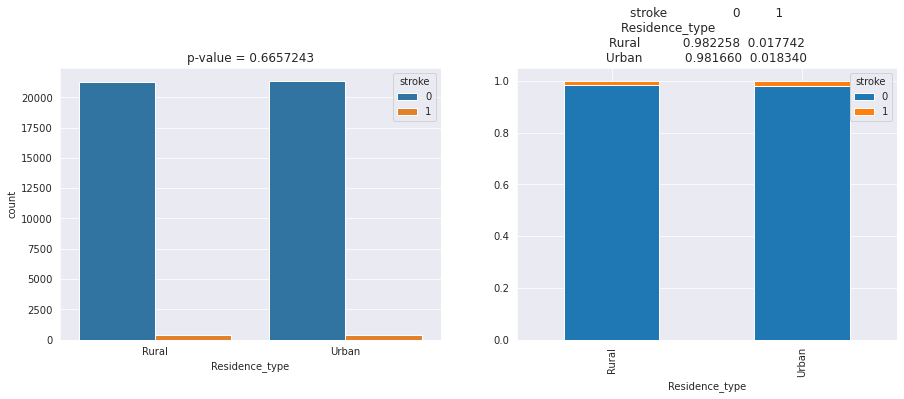

In [14]:
cat_vs_stroke('Residence_type')

People with and without stroke are evenly distributed among the population. So we can say that this is not a significant variable for our final prediction so we will drop this. This fact is also evident from p-value of 0.66 which is far greater than our alpha 0.05

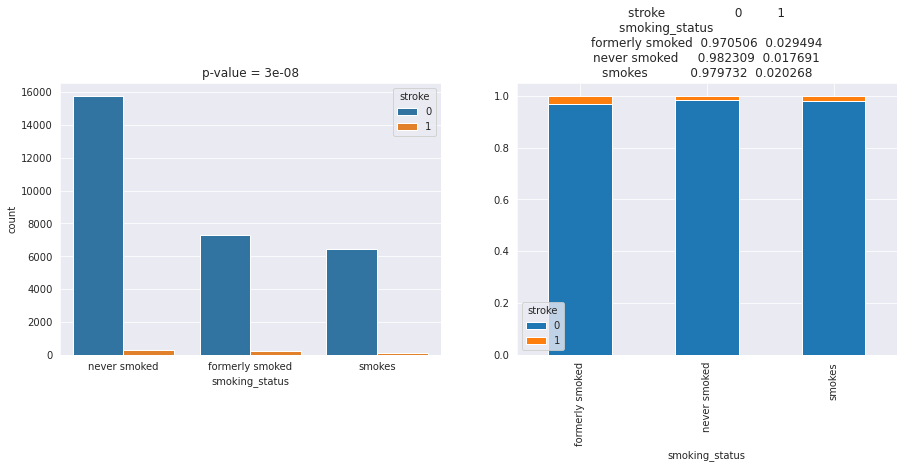

In [15]:
cat_vs_stroke('smoking_status')

The plot clearly indicates  that people who used to smoke or who currently smoke have a greater chance of getting a stroke. This is also validated by our reference. Also the p-value is less than alpha indicating this is a significant variable for our prediction

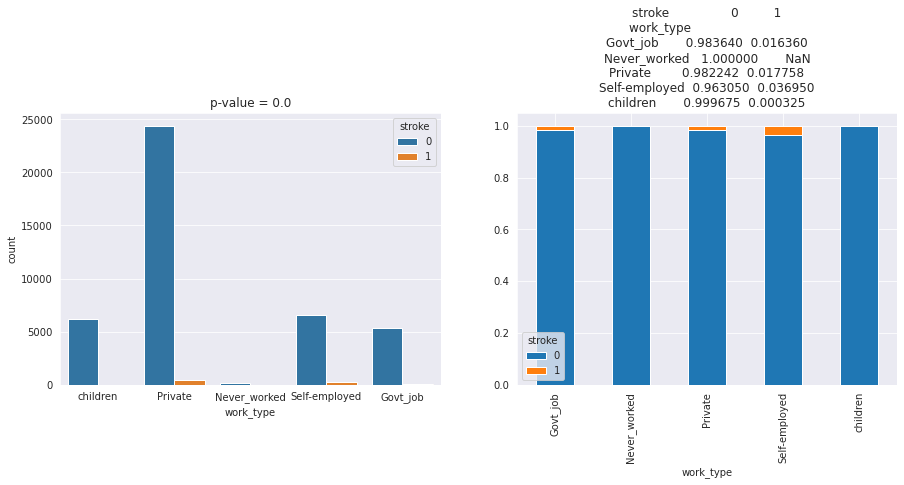

In [16]:
cat_vs_stroke('work_type')

Here never worked mostly come under children category so these two categories have low chance of stroke.
But employed people have higher chances of stroke reasons being work pressure and a stressed life. Here an interesting observation is self employed people have greater chance of getting a stroke. This can intuitively thought as they have more burden of looking at their business leading to elevated stress levels.

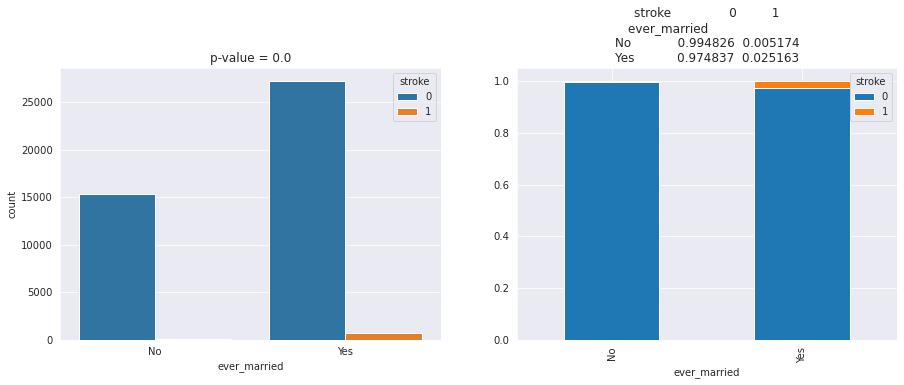

In [17]:
cat_vs_stroke('ever_married')

From the plot it indicates people who are married have more chance of stroke. It is evident from the fact that most of the time married people are higher in age than unmarried , so the reason for stroke is due to increase in age but not directly related to marriage. 

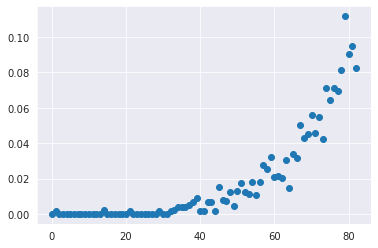

In [18]:
# Plot mean stroke rate grouped by age
ageData = train.pivot_table(index=np.round(train.age),values='stroke',aggfunc=('mean','count'))
plt.scatter(ageData.index,ageData['mean'])
plt.show()

##### The plot clearly indicates that increase in age exponentially increases the risk of having a stroke
##### Also note that below the age of 30, the risk of stroke is almost certainly 0
##### We will be considering only people above age 1 for our modelling as explained in univariate age analysis

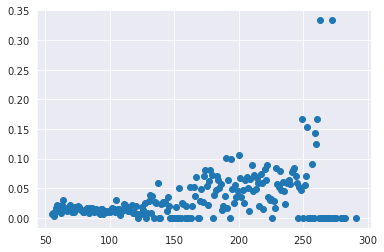

In [19]:
# Plot mean stroke rate grouped by average glucose level
glucoseData = train.pivot_table(index=np.round(train.avg_glucose_level),values='stroke',aggfunc=('mean','count'))
plt.scatter(glucoseData.index,glucoseData['mean'])
plt.show()

##### The plot indicates that with an increase in average glucose levels in the body there is an increased  risk of having a stroke.

##### Also as per our univariable analysis there are many outliers and glucose levels above 200 are extremely rare so we consider only people with glucose level less than 200 for our modelling

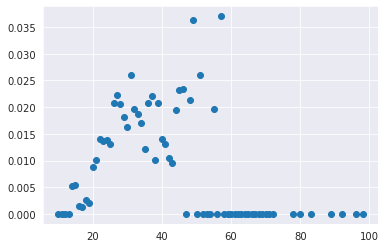

In [20]:
# Plot mean stroke rate grouped by average glucose level
BMIdata = train.pivot_table(index=np.round(train.bmi),values='stroke',aggfunc=('mean','count'))
plt.scatter(BMIdata.index,BMIdata['mean'])
plt.show()

##### The plot clearly indicates that with an increase in BMI values increases the risk of having a stroke.

##### Also as per our univariable analysis there are many outliers and BMI values above 60 are extremely rare so we consider only people with BMI less than 60 for our modelling

## Data Manipulation and imputing missing data

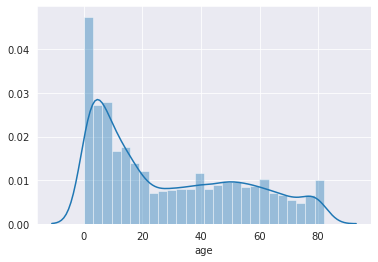

In [21]:
sns.distplot(combined[combined.smoking_status.isnull()].age)
plt.show()

From the graph it is evident that most of the missing smoke status are in ages less than 20, they can be children and teenagers. So we will impute the missing values with never smoked status 

#### Data Manipulation

In [22]:
# dropping not necessary columns for modelling
train.drop(["id","Residence_type","gender","ever_married"], axis = 1, inplace = True)
test.drop(["id","Residence_type","gender","ever_married"], axis = 1, inplace = True)

# Filling mising smoking_status as per the asumption
train['smoking_status'].fillna('never smoked',inplace = True)
test['smoking_status'].fillna('never smoked',inplace = True)

# Creating a new veriable Hyper_heart
train['Hyper_heart'] = train['hypertension']+train['heart_disease']
test['Hyper_heart'] = test['hypertension']+test['heart_disease']

# Filling missing bmi values with median
train["bmi"]= train["bmi"].fillna(train["bmi"].median())
test["bmi"]= test["bmi"].fillna(test["bmi"].median())

# removing data with age less than 1
train = train[train['age']>1]

# considering data with bmi <= 60
train = train[train['bmi']<=60]

# considering data with avg_glucose_level < 200
train = train[train['avg_glucose_level']<200]

In [23]:
# converting categorical data to numerical as per our EDA results
train['work_type'].replace(['children','Never_worked','Self-employed','Private', 'Govt_job'],[0,1,2,2,1],inplace=True)
train['smoking_status'].replace(['never smoked','formerly smoked','smokes'],[0,1,1],inplace=True)

test['work_type'].replace(['children','Never_worked','Self-employed','Private', 'Govt_job'],[0,1,2,2,1],inplace=True)
test['smoking_status'].replace(['never smoked','formerly smoked','smokes'],[0,1,1],inplace=True)

In [24]:
# Segregating the target variable
x1,y1=train.loc[:,train.columns!='stroke'],train['stroke']

In [25]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=11,stratify=y1)

In [26]:
# Scaling numerical data using Standard Scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train[['age','avg_glucose_level','bmi']] = sc.fit_transform(X_train[['age','avg_glucose_level','bmi']])
X_test[['age','avg_glucose_level','bmi']] = sc.transform(X_test[['age','avg_glucose_level','bmi']])
test[['age','avg_glucose_level','bmi']] = sc.transform(test[['age','avg_glucose_level','bmi']])

### Model Building

In [27]:
model = LogisticRegression(class_weight='balanced', fit_intercept= True, penalty= 'l2',random_state=11)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[::,1]
cv_score = cross_val_score(model,X_train,y_train,cv = 10, scoring = 'roc_auc')
print(cv_score)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_proba)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'brier_score :{brier_score_loss(y_test, y_pred_proba)}')

[0.87131967 0.89190263 0.84317559 0.87381072 0.81591457 0.83604156
 0.82850212 0.86168091 0.85779676 0.84882527]
Accuracy Score: 0.734578024473319
Area Under Curve: 0.8486496397511386
Recall score: 0.8292682926829268
brier_score :0.17309085667987517


#### ROC curve

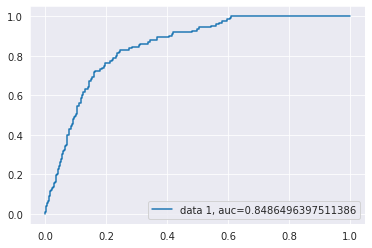

In [28]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Confusion matrix

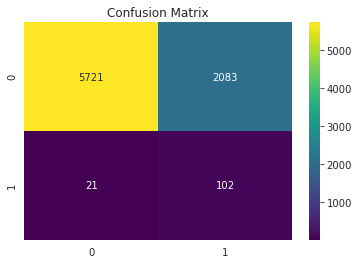

In [29]:
predictions=model.predict(X_test)
sns.heatmap(confusion_matrix(y_test,predictions), annot= True, cmap = 'viridis', fmt="2")
plt.title('Confusion Matrix')
plt.show()

#### Predictions

In [30]:
final = model.predict_proba(test)
final = final[:,1]
final

array([0.85730711, 0.91921494, 0.02706653, ..., 0.81183464, 0.34919982,
       0.16271845])

In [31]:
df = pd.read_csv('sub.csv')
df['stroke'] = final
df.to_csv('final.csv',index=False)